This notebook is for fine-tuning Open AI gpt-4o-mini model. It's reproducible if the PATHS class is set up correctly.

In [ ]:
!pip3 install openai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import numpy as np, pandas as pd
import json
from openai import OpenAI
from google.colab import userdata
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
class CONFIG:
    model = 'gpt-4o-mini-2024-07-18'
    epoch = 4
    batch_size = 4
    learning_rate_multiplier = 1.8
    lines_per_task = 1

In [5]:
class PATHS:
    save = '/content/drive/MyDrive'
    few_shot = f'{save}/few_shot_labeled.tsv'
    train = f'{save}/ft-train_labeled.tsv'
    valid = f'{save}/ft-valid_labeled.tsv'

In [6]:
client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

# Define Response Format

In [18]:
response_format = {
    "type": "json_schema",
    "json_schema": {
        "strict": True,
        "name": "harmlabels",
        "schema": {
            "type": "object",
            "properties": {
                "id": {
                    "type": "string"
                },
                "self_harm": {
                    "type": "integer",
                    "enum": [0, 1]
                },
                "harming_others": {
                    "type": "integer",
                    "enum": [0, 1]
                },
                "harmed_by_others": {
                    "type": "integer",
                    "enum": [0, 1]
                },
                "reference_to_harm": {
                    "type": "integer",
                    "enum": [0, 1]
                }
            },
            "required": [
                "id", "self_harm", "harming_others", "harmed_by_others", "reference_to_harm"
            ],
            "additionalProperties": False
        }
    }
}

# Set Prompt

In [13]:
instruction = """You are a data labeler. The targets are 'self_harm', 'harming_others', 'harmed_by_others', and 'reference_to_harm', label each target as 0 or 1.
1. 'self_harm': harm directed from me to me
2. 'harming_others': harm directed from me to other people
3. 'harmed_by_others': harm directed from other people to me
4. 'reference_to_harm': harm directed from other people to other people
"""

In [14]:
action = """Label the following texts. Return 'id', 'self_harm', 'harming_others', 'harmed_by_others', and 'reference_to_harm'. 'id' is the same as input.
"""

In [15]:
labels = ['self_harm', 'harming_others', 'harmed_by_others','reference_to_harm']

In [16]:
few_shot_df = pd.read_csv(PATHS.few_shot, sep='\t', dtype={'id': 'string'})
train_df = pd.read_csv(PATHS.train, sep='\t', dtype={'id': 'string'})
valid_df = pd.read_csv(PATHS.valid, sep='\t', dtype={'id': 'string'})
all_train_df = pd.concat([few_shot_df, train_df])

# Fine-Tune

In [ ]:
def make_fine_tune_jsonl(df, output):
    with open(output, 'w') as f:
        for i in range(len(df)):
            s = df.iloc[i]
            result = {"id": s['id']}
            for label in labels:
                result[label] = int(s[label])
            obj = {
                'messages': [
                    {
                        "role": "system",
                        "content": instruction
                    },
                    {
                        "role": "user",
                        "content": ''.join([action, s['id'], '\t', s['text']])
                    },
                    {
                        "role": "assistant",
                        "content": str(result)
                    }
                ]
            }
            f.write(json.dumps(obj) + '\n')

In [ ]:
make_fine_tune_jsonl(all_train_df, f'{PATHS.save}/fine_tune_all_train.jsonl')
make_fine_tune_jsonl(valid_df, f'{PATHS.save}/fine_tune_valid.jsonl')

Upload train and validation

In [ ]:
train_file = client.files.create(
  file=open(f'{PATHS.save}/fine_tune_all_train.jsonl', "rb"),
  purpose="fine-tune"
)
validation_file = client.files.create(
  file=open(f'{PATHS.save}/fine_tune_valid.jsonl', "rb"),
  purpose="fine-tune"
)

In [ ]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model=CONFIG.model,
    hyperparameters={
        "n_epochs": CONFIG.epoch,
        "batch_size": CONFIG.batch_size,
        "learning_rate_multiplier": CONFIG.learning_rate_multiplier
    }
)

In [ ]:
fine_tuning_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
print(fine_tuning_job)

In [ ]:
fine_tuned_model = fine_tuning_job.fine_tuned_model
print(fine_tuned_model)

# Make Inference

In [8]:
def split_text(filename):
    split = []
    df = pd.read_csv(filename, sep='\t').drop(labels, axis=1)
    for i in range(0, len(df), CONFIG.lines_per_task):
        text = df.iloc[i: i+CONFIG.lines_per_task].to_csv(sep='\t', index=False, header=False)
        split.append((i//CONFIG.lines_per_task, text))
    return split

In [9]:
def get_task(index, text, model):
    task = {
        "custom_id": f"task_{index}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": model,
            "temperature": 0,
            "max_tokens": 256,
            "response_format": response_format,
            "messages": [
                {
                    "role": "system",
                    "content": instruction,
                },
                {
                    "role": "user",
                    "content": ''.join([action, text]),
                },
            ],
        },
    }
    return task

In [10]:
def make_inference_jsonl(input, output, model):
    split = split_text(input)
    # write jsonl
    with open(output, 'w') as f:
        for index, text in split:
            task = get_task(index, text, model)
            f.write(json.dumps(task) + '\n')

In [11]:
def submit_batch(jsonl_file):
    # upload jsonl
    batch_file = client.files.create(
        file=open(jsonl_file, 'rb'),
        purpose="batch",
    )
    # submit batch job
    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
    )
    return batch_job

In [19]:
inference_jsonl = f'{PATHS.save}/inference.jsonl'
make_inference_jsonl(PATHS.valid, inference_jsonl, fine_tuned_model)

In [20]:
batch_job = submit_batch(inference_jsonl)

In [ ]:
batch_job = client.batches.retrieve(batch_job.id)
print(batch_job)

In [25]:
result_file_id = batch_job.output_file_id
result = client.files.content(result_file_id).content
valid_predicted_jsonl = f'{PATHS.save}/valid_predicted.jsonl'
with open(valid_predicted_jsonl, 'wb') as f:
    f.write(result)

# Process Inference Result

In [26]:
def get_df(jsonl):
    with open(jsonl) as f:
        json_lines = f.readlines()
        json_objs = [json.loads(line) for line in json_lines]
    df = pd.DataFrame(columns=(['id']+labels))
    for i, json_obj in enumerate(json_objs):
        json_content = json.loads(json_obj['response']['body']['choices'][0]['message']['content'])
        s = pd.Series(data=json_content)
        df.loc[i] = s
    for label in labels:
        df[label] = df[label].astype('int')
    return df

In [34]:
def compare_labels(true_df, predicted_df):
    merged = pd.merge(true_df, predicted_df, how='inner', on='id', suffixes=('_true', '_predicted'))
    plt.rcParams.update({'font.size': 8})
    for label in labels:
        true = merged[f'{label}_true']
        predicted = merged[f'{label}_predicted']
        print(f'label: {label}')
        # print classification report
        print(classification_report(true, predicted))
        # display confusion matrix
        cm = confusion_matrix(true, predicted)
        cmdisplay = ConfusionMatrixDisplay(cm)
        cmdisplay.plot()
        plt.show()
        print('\n')
    mask = ( (merged['self_harm_true'] != merged['self_harm_predicted']) | (merged['harming_others_true'] != merged['harming_others_predicted']) |
             (merged['harmed_by_others_true'] != merged['harmed_by_others_predicted']) | (merged['reference_to_harm_true'] != merged['reference_to_harm_predicted']) )
    diff = merged[mask]
    return diff

In [32]:
valid_predicted_df = get_df(valid_predicted_jsonl)

label: self_harm
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        79
           1       0.86      1.00      0.93        19

    accuracy                           0.97        98
   macro avg       0.93      0.98      0.95        98
weighted avg       0.97      0.97      0.97        98



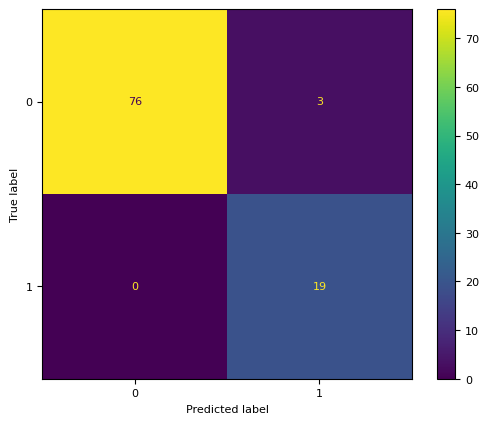



label: harming_others
              precision    recall  f1-score   support

           0       0.99      0.93      0.95        80
           1       0.74      0.94      0.83        18

    accuracy                           0.93        98
   macro avg       0.86      0.93      0.89        98
weighted avg       0.94      0.93      0.93        98



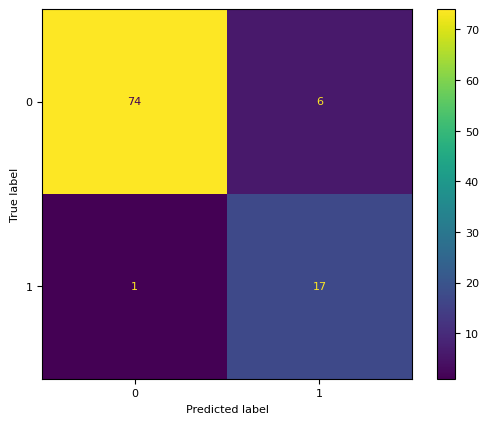



label: harmed_by_others
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        77
           1       0.90      0.90      0.90        21

    accuracy                           0.96        98
   macro avg       0.94      0.94      0.94        98
weighted avg       0.96      0.96      0.96        98



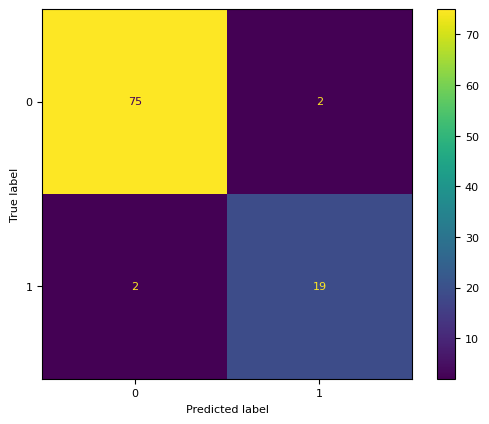



label: reference_to_harm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       1.00      0.86      0.92         7

    accuracy                           0.99        98
   macro avg       0.99      0.93      0.96        98
weighted avg       0.99      0.99      0.99        98



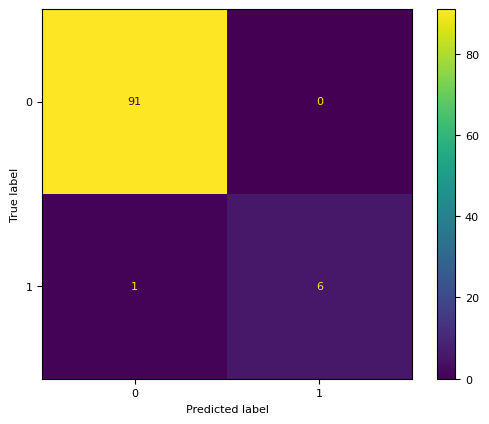

In [35]:
diff = compare_labels(valid_df, valid_predicted_df)